In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import UnivariateSpline, interp1d
import time
import urllib, urllib2

In [31]:
def create_SQL_query(RA, DEC, d):
    query_str = '''
    SELECT
        p.objid, p.ra, p.dec, p.devrad_r, p.fracdev_r, p.exprad_r, s.z as redshift, 
        p.modelmag_u, p.modelmag_g, p.modelmag_r, p.modelmag_i, p.modelmag_z, 
        p.petrorad_r, petroR50_r, p.clean 
    FROM PhotoObj AS p
      JOIN dbo.fGetNearbyObjEq({}, {}, {}) AS GN ON p.objID = GN.objID
      JOIN SpecObj AS s ON s.bestobjid = p.objid
    WHERE petroR50_r < 3.0
      AND s.z > 0.0002
      AND ((flags_r & 0x10000000) != 0)
      AND ((flags_r & 0x8100000c00a4) = 0)
      AND (((flags_r & 0x400000000000) = 0) or (psfmagerr_r <= 0.2))'''.format(RA, DEC, d)
    return query_str
#       JOIN TwoMass AS m2 ON m2.objID = p.objid\
#       JOIN WISE_xmatch AS wx ON wx.sdss_objid = p.objid\
#       JOIN WISE_allsky AS w ON w.cntr = wx.wise_cntr\
# WHERE s.class = "STAR"\
#       AND s.snMedian > 25.0\


In [32]:
def SDSS_request(SQL_query):
    # sends SQL query to DR7 SQL search, returns as csv
    sURL = 'http://cas.sdss.org/dr7/en/tools/search/x_sql.asp'
    values = {'cmd': SQL_query, 'format': 'csv'}
    data = urllib.urlencode(values)
    request = urllib2.Request(sURL, data)
    response = urllib2.urlopen(request)
    return response.read()

# data = SDSS_request(thequery)
# print data

In [35]:
import sys 

def writer(name,RA,DEC,data):
    # Function to write data to a file
    f = open(name, 'a')             #defines the file to be opened as appendable
    #f.write('\n' + host + '\n')     #formatting for hosts
    f.write(data)                   #writes in data
    f.close()                       #tells python to close file
    return writer

def colorplotter(RA,DEC,d=.05):
    file_name = 'color{:.0f}.csv'.format(time.time())
    print 'Creating file:', file_name
    the_file = open(file_name, 'w')
    the_file.write('objid,ra,dec,devrad_r,fracdev_r,exprad_r,redshift,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,petrorad_r,petroR50_r,clean\n')
    the_file.close()
    
    query_string = ''
    data_string = ''
    full_data = ''
    for i, val in enumerate(RA):
        sys.stdout.write('\r'+'Retrieving Data: {0:.1f}%'.format((i/np.float(len(RA)))*100.))

        query_string = create_SQL_query(RA[i],DEC[i], d)
        data_string = SDSS_request(query_string)
        
        if data_string == 'No objects have been found':
            #print 'No objects here.'
            continue
        else:
            split_string = data_string.split('clean\n')[1]
            #print split_string
            if split_string in full_data:
                continue
            else:
                full_data += split_string
    writer(file_name,RA[i],DEC[i],full_data)
    
    data = np.genfromtxt('{}'.format(file_name), skip_header=0, names=True, delimiter=',', skip_footer=0, unpack=True);
#     name = np.genfromtxt("file_name", dtype=str,skip_header=0,usecols=0);
    good_colors = ((data['modelmag_u'] < 26) & (data['modelmag_g'] < 26) & (data['modelmag_r'] < 26) \
                   & (data['modelmag_i'] < 26) & (data['modelmag_z'] < 26) & (data['modelmag_u'] > 0))
    u = data['modelmag_u'][good_colors]
    g = data['modelmag_g'][good_colors]
    r = data['modelmag_r'][good_colors]
    i = data['modelmag_i'][good_colors]
    z = data['modelmag_z'][good_colors]
    redshift = data['redshift'][good_colors]
    pet_r = data['petrorad_r'][good_colors]
    color_ug = u-g
    color_ur = u-r
    color_ui = u-i
    color_uz = u-z
    color_gr = g-r
    color_gi = g-i
    color_gz = g-z
    color_ri = r-i
    color_rz = r-z
    colors = [color_ug, color_ur, color_ui, color_uz, color_gr, color_gi, color_gz, color_ri, color_rz]
    colornames = ['color_ug', 'color_ur', 'color_ui', 'color_uz', 'color_gr', 'color_gi', 'color_gz', 'color_ri', 'color_rz']
    height_ratios = [5, 5, 5, 5, 5, 5]
    width_ratios = [5, 5, 5, 5, 5, 5]
    wspace = 1.25
    hspace = 1.25
    x = 0
    y = 0
    fig = plt.figure(figsize=(sum(width_ratios) + wspace *
                              (len(width_ratios) - 1),
                              sum(height_ratios) + hspace *
                              (len(height_ratios) - 1)))
    gs = gridspec.GridSpec(len(height_ratios),
                           len(width_ratios),
                           height_ratios=height_ratios,
                           width_ratios=width_ratios)

    fig.suptitle('', fontsize=20)
    location = 0
    for i, icolor in enumerate(colors):
        for j, jcolor in enumerate(colors):
            if i != j and j > i:
                ax = fig.add_subplot(gs[location])
                ax.scatter(icolor, jcolor, c='navy',marker='o',alpha='.25', s = 5);
#                 fit = np.polyfit(icolor, jcolor, 1)
#                 fit = np.poly1d(fit_data_johnson_R)
#                 fit_x = np.linspace(min(data_johnson_R['R_in']), max(data_johnson_R['R_in']), 10000)
    #             for k, kval in enumerate(name[0]):
    #                ax.annotate(kval, xy=(icolor[k],jcolor[k]));
                ax.update({'title': '',
                            'ylabel': '{}'.format(colornames[j]),
                            'xlabel': '{}'.format(colornames[i])})
                ax.set_facecolor('whitesmoke')
                ax.patch.set_alpha(.25)
    #             ax.set_xlim((min(icolor)*.9, max(icolor)*1.1))
    #             ax.set_ylim((min(jcolor)*.9, max(jcolor)*1.1))

                plt.minorticks_on()
                plt.tick_params('both', length=8, which='major')
                plt.tick_params('both',length=3, which='minor')
                plt.grid(True, which='major', ls='dashed', alpha=.5)
                plt.grid(True, which='minor', ls='dashed', alpha=.15)
                location += 1
    plt.savefig('fig.png')
    plt.show()

In [15]:
# chrisdata = np.genfromtxt("chrisdata3.txt", skip_header=0, names=True, delimiter=',', skip_footer=0, unpack=True);

In [53]:
stephdata = np.genfromtxt("stephanieradec.csv", delimiter=',', skip_footer=0, unpack=True)
print stephdata[1]


[   8.19389   11.71141  113.80182  148.33406  148.35924  148.57085  201.47
  211.21952  187.73909  187.97039  187.7995   187.06596]
[nan, 11.711410000000001, -20.651409999999998]
[nan, 113.80182000000001, 65.721080000000001]


Creating file: color1509489847.csv
Retrieving Data: 100.0%

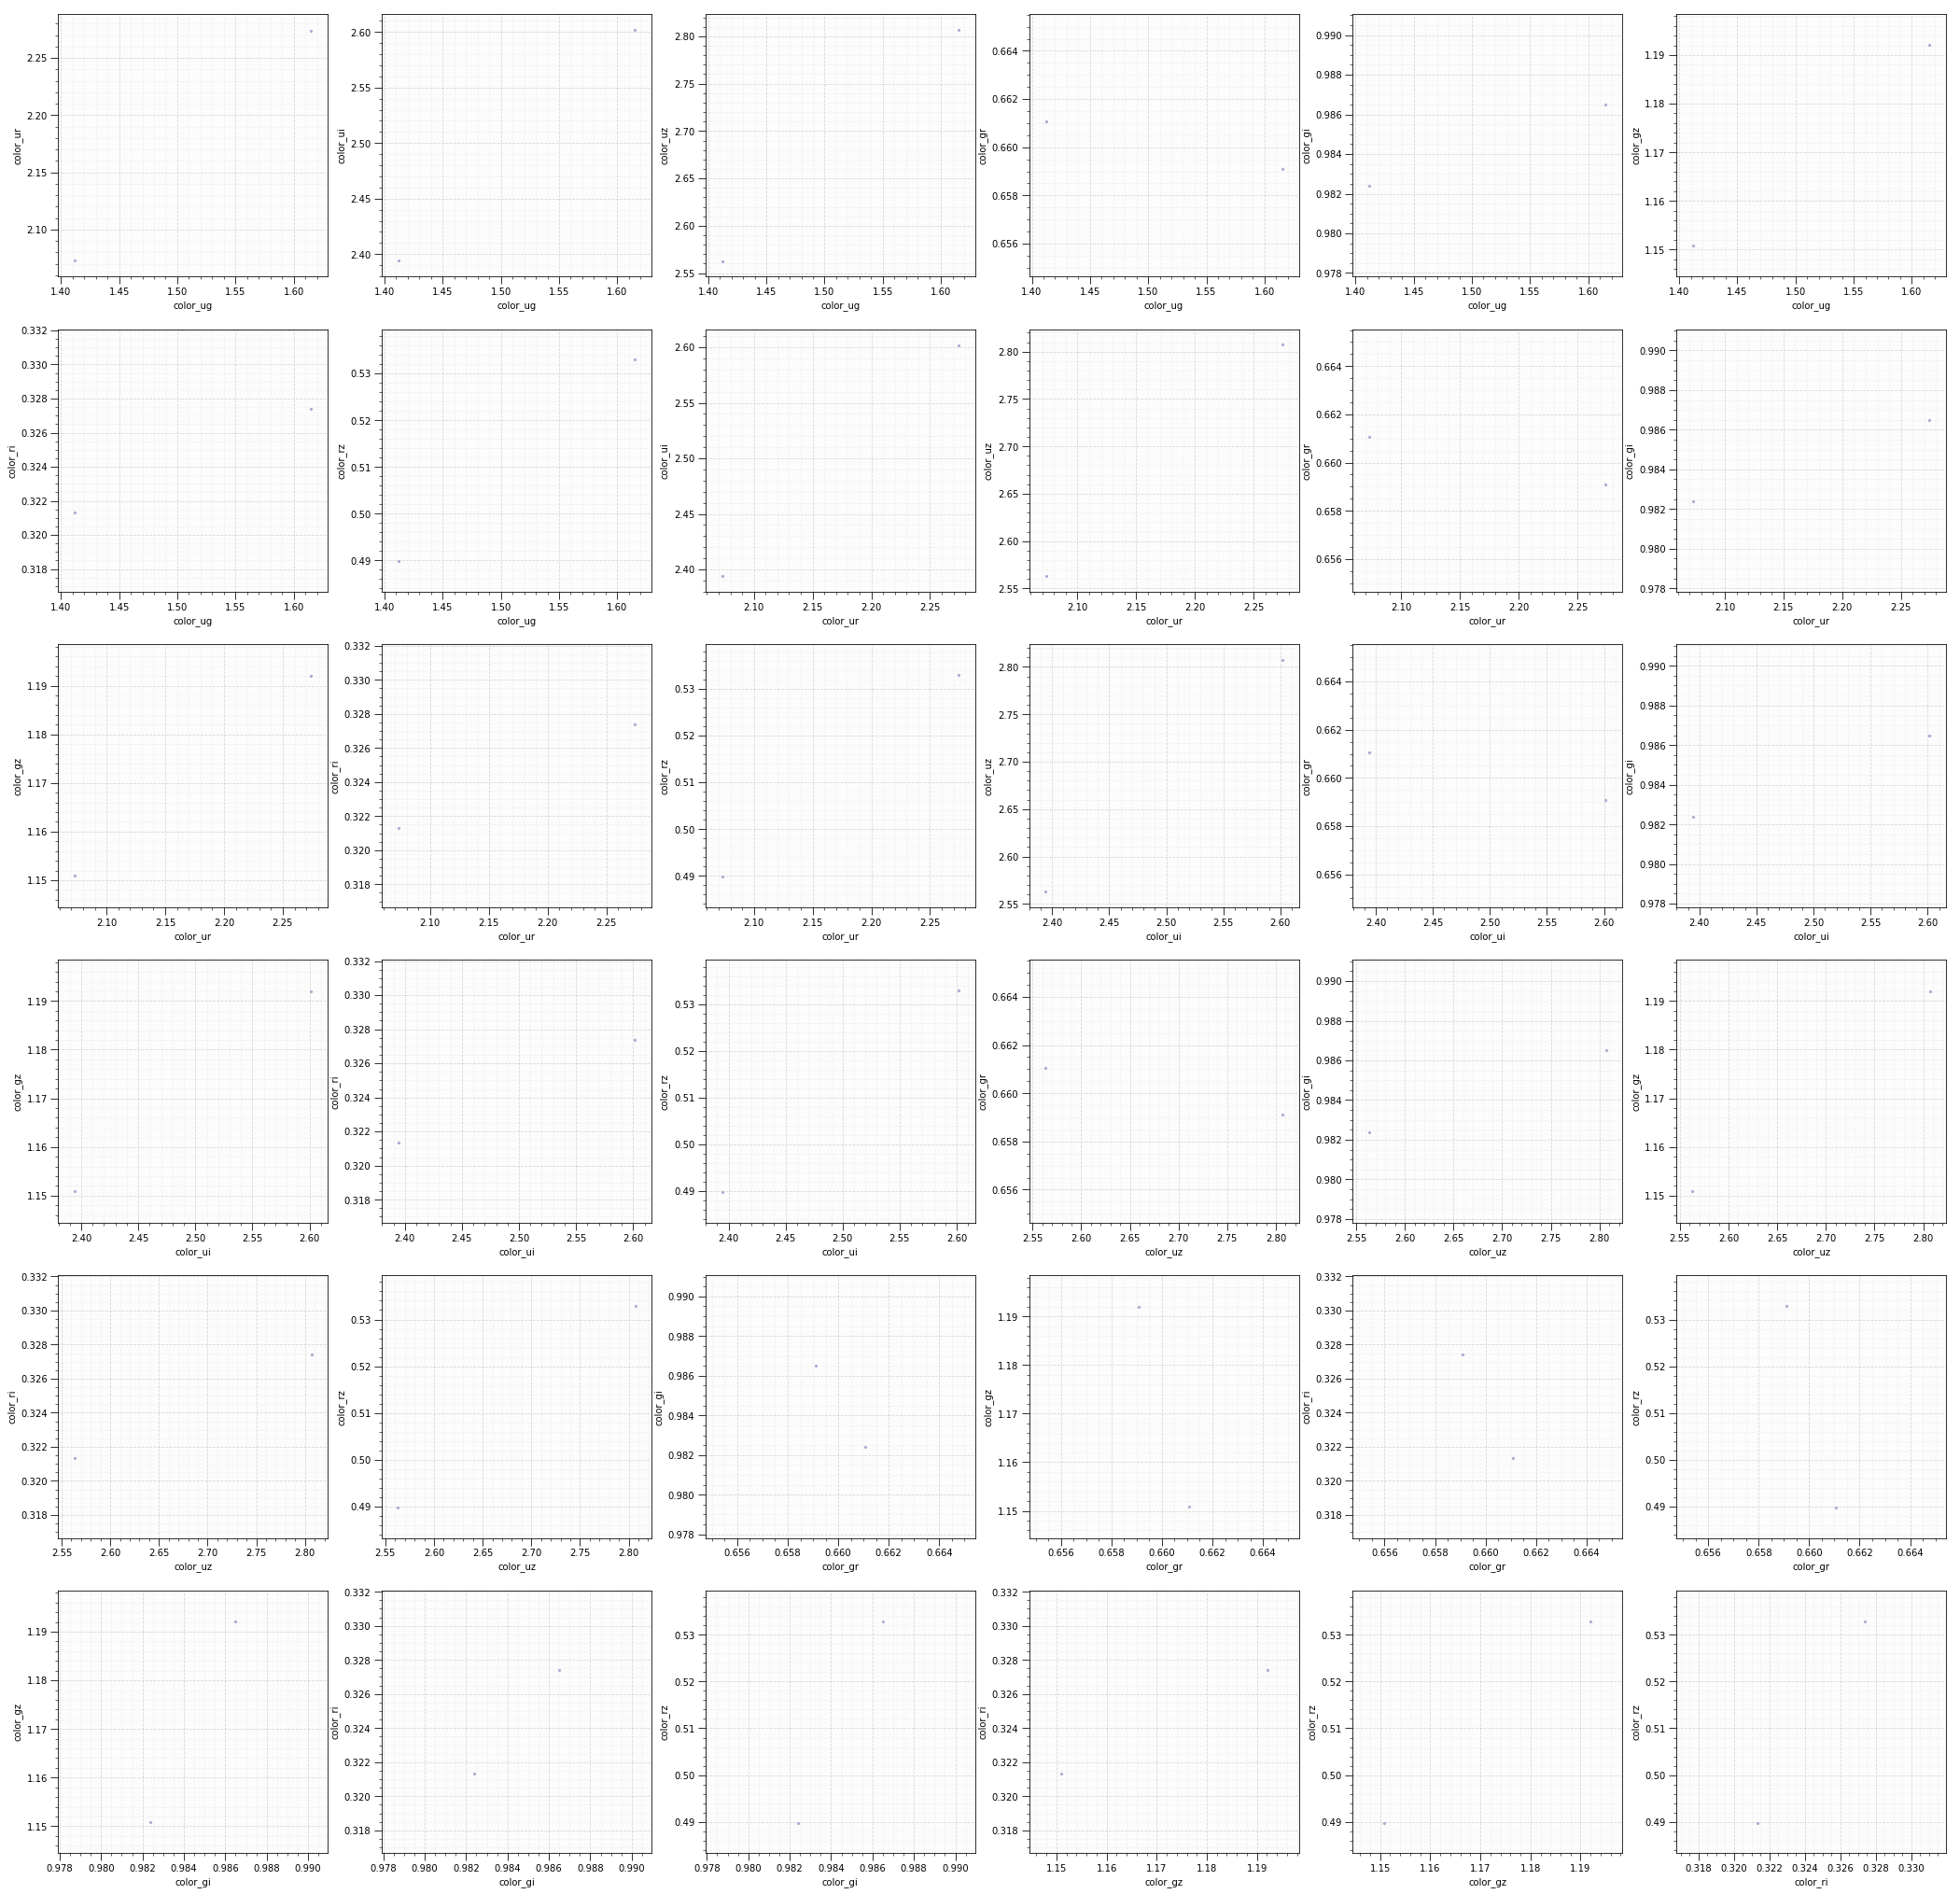

In [57]:
colorplotter(stephdata[1], stephdata[2], d=.002)